# Домашнее задание

**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?



**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

In [ ]:
!pip install implicit==0.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
import implicit
from implicit import als


# Модель второго уровня
# from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

## Read data

In [ ]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# Process features dataset

In [ ]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [ ]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [ ]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [ ]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [ ]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [ ]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [ ]:
# выше видим разброс по пользователям и товарам

In [ ]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [ ]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/content/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [ ]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


In [ ]:
# Теперь warm-start по пользователям

# Задание 1.

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?

Пока пробуем отобрать 50 кандидатов (k=50)
Качество измеряем на data_val_matcher: следующие 6 недель после трейна
Дают ли own recommendtions + top-popular лучший recall?

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?



In [ ]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [ ]:
ACTUAL_COL = 'actual'

In [ ]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

In [ ]:
# N = Neighbors
N_PREDICT = 500

In [ ]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))
pop = list(recommender.top_purchases.item_id[:N_PREDICT])
result_eval_matcher['pop_rec'] = result_eval_matcher['user_id'].apply(lambda x: pop)
result_eval_matcher['own+pop_rec'] = result_eval_matcher['own_rec'] + result_eval_matcher['pop_rec']
result_eval_matcher['own_rec+sim_item_rec'] = result_eval_matcher['own_rec'] + result_eval_matcher['sim_item_rec']


CPU times: user 1min 23s, sys: 51.6 s, total: 2min 15s
Wall time: 1min 14s


In [ ]:
%%time
# result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 7.87 µs


In [ ]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [ ]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@50 of matching

In [ ]:
TOPK_RECALL = 50

In [ ]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.06525657038145175),
 ('own+pop_rec', 0.06525657038145175),
 ('own_rec+sim_item_rec', 0.06525657038145175),
 ('als_rec', 0.04826842051072032),
 ('sim_item_rec', 0.032957639579065466),
 ('pop_rec', 0.021002732977743847)]

In [ ]:
def recall_at_kk_own(data, kk):
  results = []
  for k in kk:
    results.append(data.apply(lambda row: recall_at_k(row['own_rec'], row[ACTUAL_COL], k=k), axis=1).mean())
  plt.plot(kk,results)

In [ ]:
examples = [i for i in range(5,500, 30)]

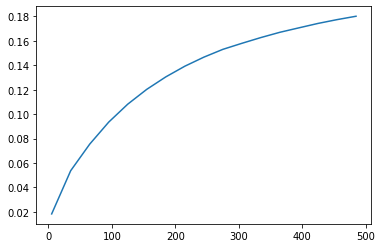

In [ ]:
recall_at_kk_own(result_eval_matcher, examples)

### Precision@5 of matching

In [ ]:
TOPK_PRECISION = 5

In [ ]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.17712691771268974),
 ('own+pop_rec', 0.17712691771268974),
 ('own_rec+sim_item_rec', 0.17712691771268974),
 ('als_rec', 0.1189214318921421),
 ('sim_item_rec', 0.05736866573686701),
 ('pop_rec', 0.013110181311018099)]

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

## Подготовка данных для трейна

In [ ]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [ ]:
N_PREDICT = 50

In [ ]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))


In [ ]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [ ]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [ ]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [ ]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


### Check warm start

In [ ]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (107550, 2) Users: 2151 Items: 4574


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [ ]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [ ]:
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


#### Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [ ]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [ ]:
df_ranker_train.target.value_counts()

0.0    99177
1.0     7795
Name: target, dtype: int64

In [ ]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


(!) На каждого юзера 50 item_id-кандидатов

In [ ]:
df_ranker_train['target'].mean()

0.07286953595333358

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

## Подготавливаем фичи для обучения модели

In [ ]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [ ]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [ ]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106972 entries, 0 to 106971
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               106972 non-null  int64  
 1   item_id               106972 non-null  int64  
 2   target                106972 non-null  float64
 3   manufacturer          106972 non-null  int64  
 4   department            106972 non-null  object 
 5   brand                 106972 non-null  object 
 6   commodity_desc        106972 non-null  object 
 7   sub_commodity_desc    106972 non-null  object 
 8   curr_size_of_product  106972 non-null  object 
 9   age_desc              39519 non-null   object 
 10  marital_status_code   39519 non-null   object 
 11  income_desc           39519 non-null   object 
 12  homeowner_desc        39519 non-null   object 
 13  hh_comp_desc          39519 non-null   object 
 14  household_size_desc   39519 non-null   object 
 15  

In [ ]:
pd.options.display.max_columns = None

In [ ]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [ ]:
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['user_id','manufacturer'],as_index=False)['item_id'].count(), on=['user_id','manufacturer'], how='left')
df_ranker_train = df_ranker_train.rename({'item_id_y': 'user_id_manufacturer_freq','item_id_x' : 'item_id' }, axis='columns')

In [ ]:
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['user_id','department'],as_index=False)['item_id'].count(), on=['user_id','department'], how='left')
df_ranker_train = df_ranker_train.rename({'item_id_y': 'user_department_freq','item_id_x' : 'item_id' }, axis='columns')

In [ ]:
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['item_id','department'],as_index=False)['user_id'].count(), on=['item_id','department'], how='left')
df_ranker_train = df_ranker_train.rename({'user_id_y': 'item_department_freq','user_id_x' : 'user_id' }, axis='columns')

In [ ]:
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['age_desc', 'item_id'],as_index=False)['user_id'].count(), on=['age_desc', 'item_id'], how='left')
df_ranker_train = df_ranker_train.rename({'user_id_y': 'age_desc_item_freq','user_id_x' : 'user_id' }, axis='columns')

In [ ]:
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['department', 'brand','user_id'],as_index=False)['item_id'].count(), on=['department', 'brand','user_id'], how='left')
df_ranker_train = df_ranker_train.rename({'item_id_y': 'brand_pop','item_id_x' : 'item_id' }, axis='columns')

In [ ]:
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['income_desc','item_id'],as_index=False)['user_id'].count(), on=['income_desc','item_id'], how='left')
df_ranker_train = df_ranker_train.rename({'user_id_y': 'money_pop','user_id_x' : 'user_id' }, axis='columns')

In [ ]:

#df_ranker_train['pop_item'] = pd.cut(df_ranker_train['pop_item'],bins=[1,18,25,39,486],right=False,labels=['low','medium','high','wery_high'])

In [ ]:
df_ranker_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106972 entries, 0 to 106971
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   user_id                    106972 non-null  int64  
 1   item_id                    106972 non-null  int64  
 2   target                     106972 non-null  float64
 3   manufacturer               106972 non-null  int64  
 4   department                 106972 non-null  object 
 5   brand                      106972 non-null  object 
 6   commodity_desc             106972 non-null  object 
 7   sub_commodity_desc         106972 non-null  object 
 8   curr_size_of_product       106972 non-null  object 
 9   age_desc                   39519 non-null   object 
 10  marital_status_code        39519 non-null   object 
 11  income_desc                39519 non-null   object 
 12  homeowner_desc             39519 non-null   object 
 13  hh_comp_desc               39

In [ ]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id_manufacturer_freq,user_department_freq,item_department_freq,age_desc_item_freq,brand_pop,money_pop
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14,4,26,4.0,2,3.0
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1,34,46,7.0,25,8.0
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14,6,8,2.0,2,2.0
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1,6,269,50.0,4,39.0
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14,6,12,2.0,2,2.0


In [ ]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [ ]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'user_id_manufacturer_freq',
 'user_department_freq',
 'item_department_freq',
 'age_desc_item_freq',
 'brand_pop',
 'money_pop']

## Обучение модели ранжирования

In [ ]:
from lightgbm import LGBMClassifier


In [ ]:
# делали на вебинаре, кусок с катбустом

# from catboost import CatBoost, Pool

# df_bin_feat = pd.get_dummies(X_train)

# model = CatBoost(params ={'objective': "Logloss",
#                           "iterations":1000,
#                           "max_depth":8,
#                           "task_type":"GPU",
#                           "devices":"0:1:2:3"
#             })
# model.fit(df_bin_juice, y_train, silent=True)

# train_preds = model.predict(df_bin_feat,prediction_type="Probability")

In [ ]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats,
                     n_jobs=-1,
#                      verbose=0
                   )

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [ ]:
df_ranker_predict = df_ranker_train.copy()

In [ ]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [ ]:
df_ranker_predict['proba_item_purchase'][:10]

0    0.055261
1    0.018833
2    0.040238
3    0.000633
4    0.432046
5    0.060660
6    0.046298
7    0.000762
8    0.205107
9    0.323101
Name: proba_item_purchase, dtype: float64

## Подведем итоги

    Мы обучили модель ранжирования на покупках из сета data_train_ranker и на кандитатах от own_recommendations, что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

# Evaluation on test dataset

In [ ]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


## Eval matching on test dataset

In [ ]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 10 s, sys: 123 ms, total: 10.2 s
Wall time: 10.1 s


In [ ]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1444117647058813)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [ ]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [ ]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [ ]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.17754569190600347)
('own_rec', 0.1444117647058813)


/content/metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)
